In [1]:
import warnings

import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from IPython.display import display
from pylab import rcParams
from datetime import  datetime, timedelta
from pandas.tseries.offsets import BDay
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
electricity_data = pd.read_csv('../b. Datasets/Electricity Demand/Electricity Demand.csv')

In [3]:
electricity_data.shape

(731, 2)

In [4]:
electricity_data.describe()

,demand
count,731.000000
mean,123324.026252
std,13323.048125
min,90227.480000
25%,114437.497500
50%,123301.835000
75%,132856.720000
max,160285.015000


In [5]:
electricity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    731 non-null    object 
 1   demand  731 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.6+ KB


In [6]:
electricity_data.isna().sum()

date      0
demand    0
dtype: int64

In [7]:
display(electricity_data.head(2))
display(electricity_data.tail(2))

,date,demand
0,2015-01-01,99635.03
1,2015-01-02,129606.01


,date,demand
729,2016-12-30,112141.83
730,2016-12-31,95728.15


## Converting the date column to index after type casting.

In [8]:
electricity_data['date'] = pd.to_datetime(electricity_data['date'], errors='coerce')

In [9]:
electricity_data.isna().sum()

date      0
demand    0
dtype: int64

In [10]:
date_range_vals = pd.date_range(start=electricity_data['date'][0], 
                                end=electricity_data['date'][len(electricity_data) - 1], 
                                freq='D')
len(date_range_vals)

731

In [11]:
date_range_vals[:2], date_range_vals[-2:]

(DatetimeIndex(['2015-01-01', '2015-01-02'], dtype='datetime64[ns]', freq='D'),
 DatetimeIndex(['2016-12-30', '2016-12-31'], dtype='datetime64[ns]', freq='D'))

In [12]:
electricity_data.set_index(date_range_vals, inplace=True)
electricity_data.drop(labels='date', axis=1, inplace=True)

In [13]:
display(electricity_data.head(2))
display(electricity_data.tail(2))

,demand
2015-01-01,99635.03
2015-01-02,129606.01


,demand
2016-12-30,112141.83
2016-12-31,95728.15


## Plots to visualise the data.

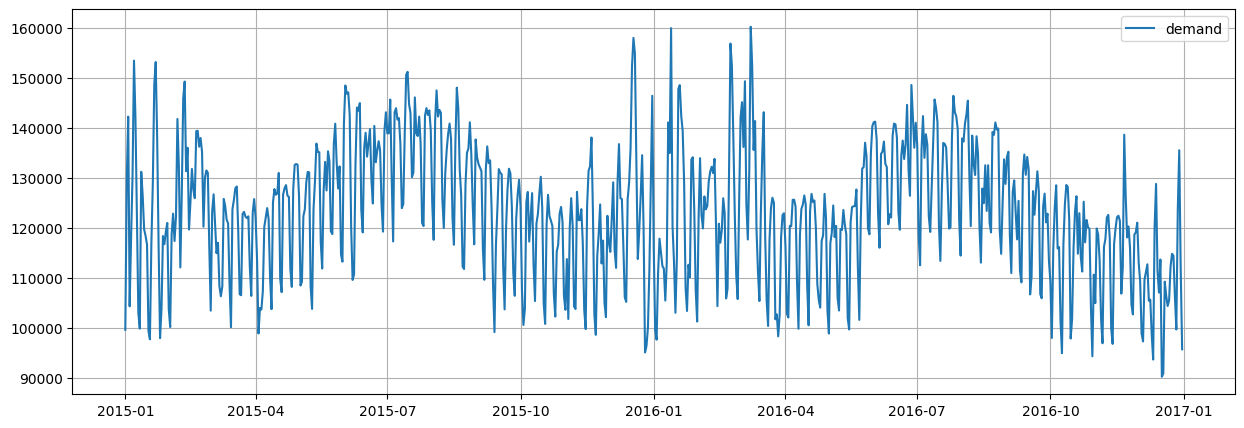

In [14]:
plt.figure(figsize=(15, 5))
sns.lineplot(electricity_data)
plt.grid()
plt.show()

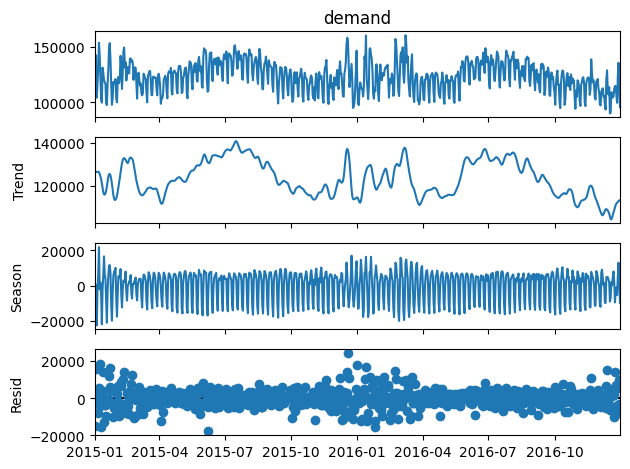

In [15]:
demand_values = electricity_data['demand']

decomposition = STL(demand_values).fit()
decomposition.plot()
plt.tight_layout()
plt.show()

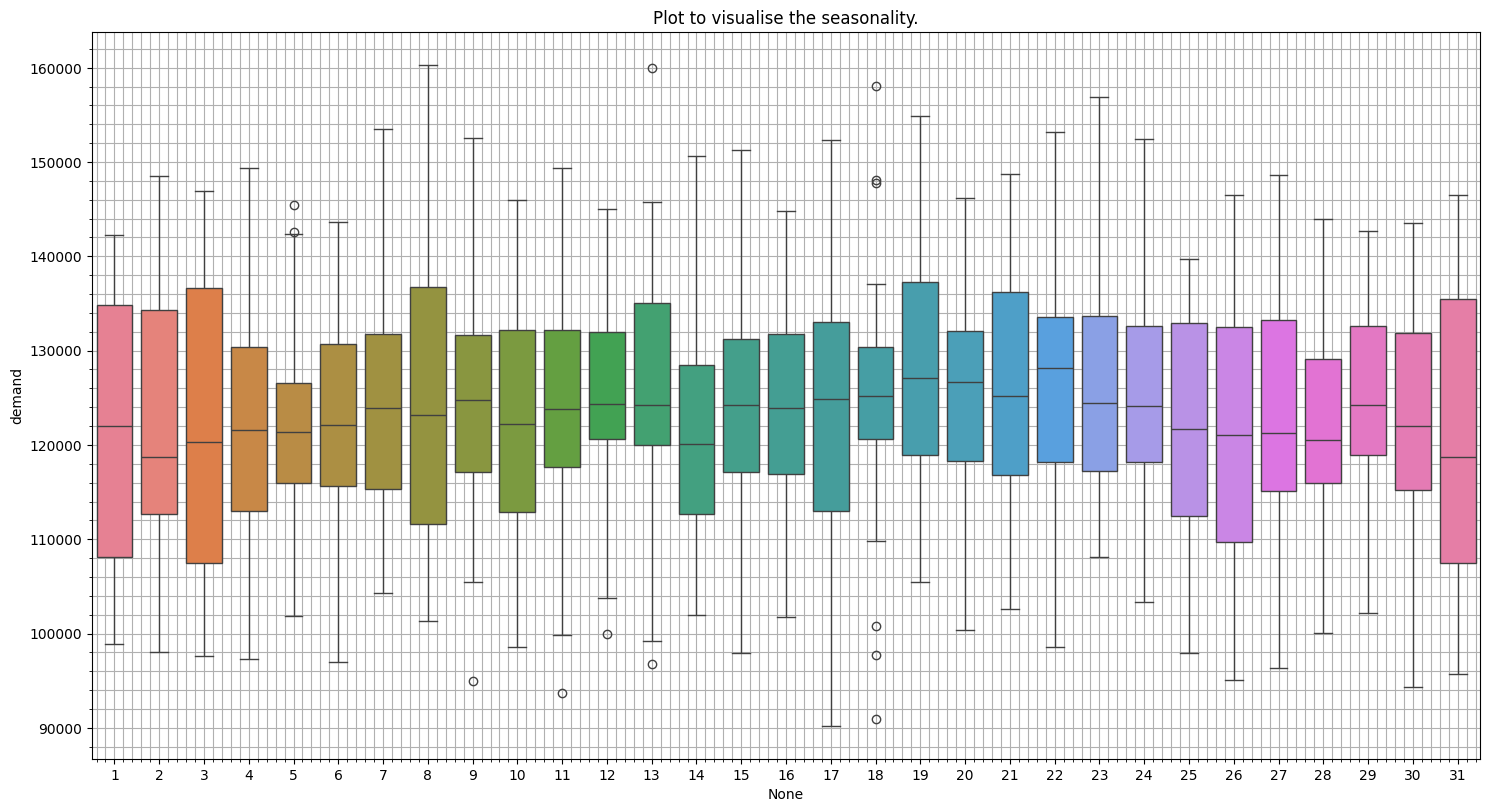

In [16]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=electricity_data.index.day, 
            y=electricity_data['demand'], 
            palette="husl")
plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.title("Plot to visualise the seasonality.")
plt.show()

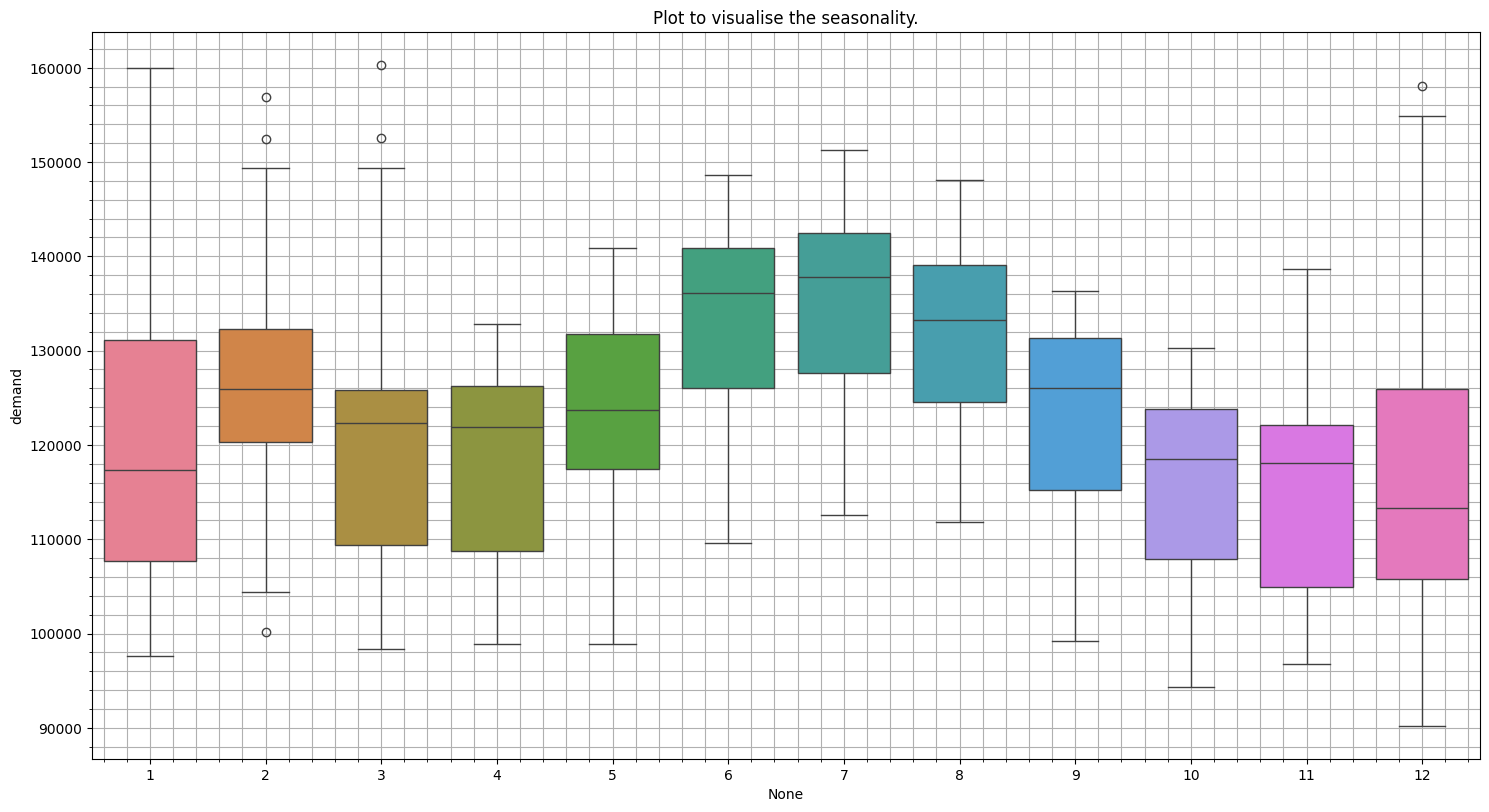

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=electricity_data.index.month, 
            y=electricity_data['demand'], 
            palette="husl")
plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.title("Plot to visualise the seasonality.")
plt.show()

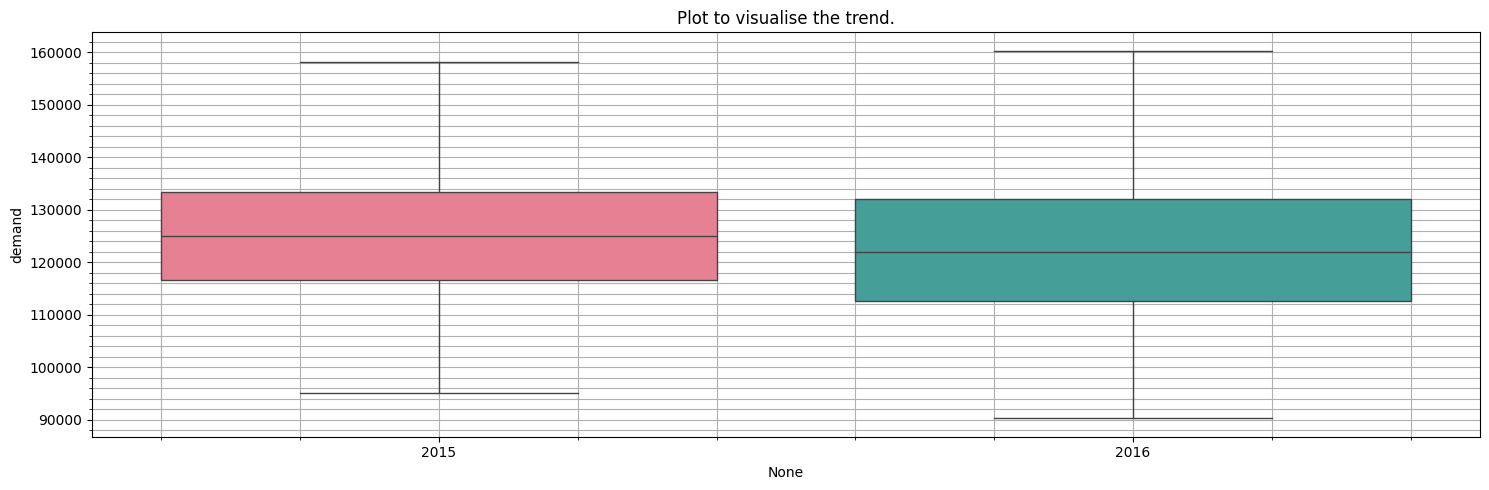

In [18]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=electricity_data.index.year, 
            y=electricity_data['demand'], 
            palette="husl")
plt.minorticks_on()
plt.grid(which='both')
plt.title("Plot to visualise the trend.")
plt.tight_layout()
plt.show()

## ADFuller - Augmented Dickey Fuller Test

In [19]:
def is_stationary(data):
    adf_stat_vals = adfuller(data)
    p_val = adf_stat_vals[1]
    significance_level = 0.05
    if p_val < significance_level:
        print("Null hypothesis CAN be rejected. The data IS stationary at 95% confidence.")
    else:
        print("Null hypothesis CANNOT be rejected. The data IS NOT stationary at 95% confidence.")

In [20]:
is_stationary(electricity_data)

Null hypothesis CANNOT be rejected. The data IS NOT stationary at 95% confidence.


In [21]:
electricity_data_1diff = electricity_data.diff().dropna()

In [22]:
is_stationary(electricity_data_1diff)

Null hypothesis CAN be rejected. The data IS stationary at 95% confidence.


## ACF & PACF Plots

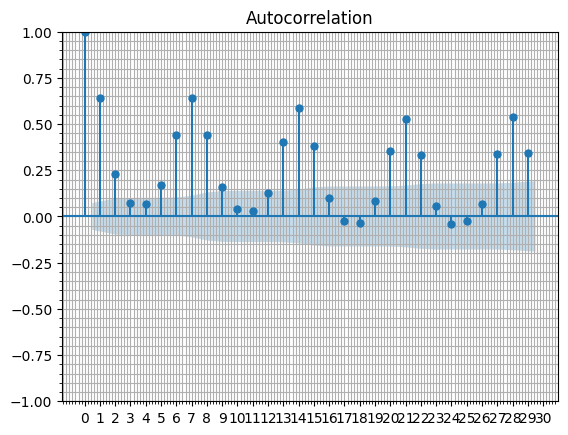

In [23]:
plot_acf(electricity_data)
plt.xticks(range(0, 31))
plt.minorticks_on()
plt.grid(which='both')
plt.show()

## Inference
- The autocorrelation is strong at multiple lags.
- The high correlation at lag 1 and a gradual decrease over subsequent lags indicate that the time series has a trend.
- The slow decay suggests non-stationarity, meaning the series is dependent on past values and exhibits persistent memory.

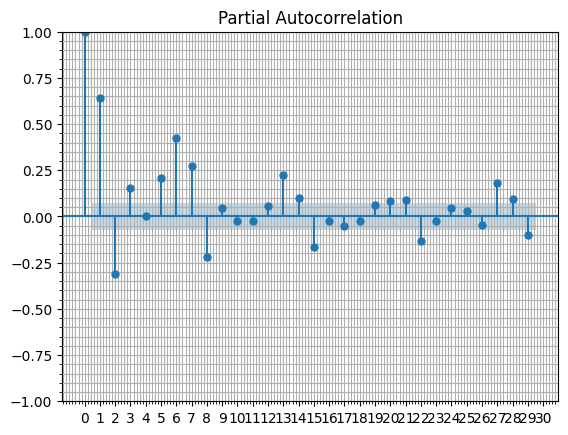

In [24]:
plot_pacf(electricity_data)
plt.xticks(range(0, 31))
plt.minorticks_on()
plt.grid(which='both')
plt.show()

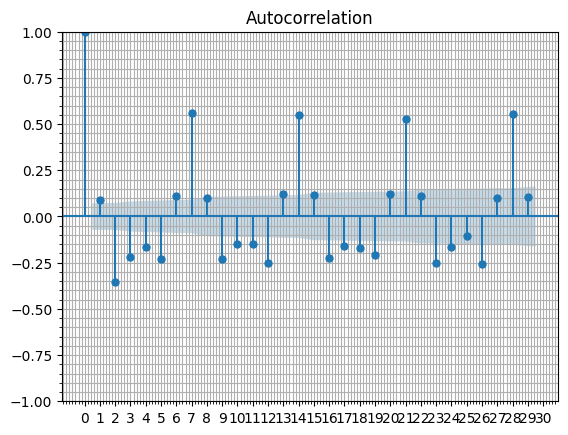

In [25]:
plot_acf(electricity_data_1diff)
plt.xticks(range(0, 31))
plt.minorticks_on()
plt.grid(which='both')
plt.show()

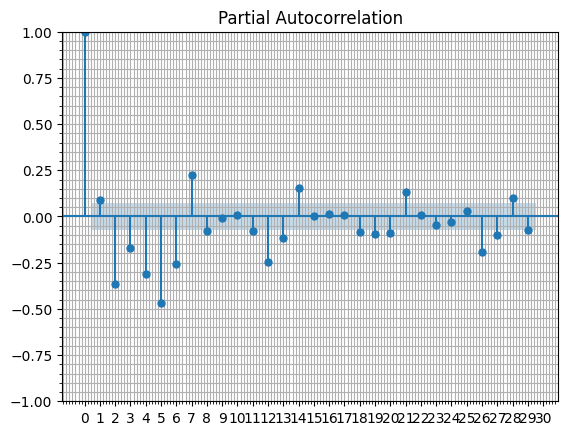

In [26]:
plot_pacf(electricity_data_1diff)
plt.xticks(range(0, 31))
plt.minorticks_on()
plt.grid(which='both')
plt.show()

## Train Test Split

In [27]:
train_data = electricity_data[:-60]
test_data = electricity_data[-60:]

train_data.shape, test_data.shape

((671, 1), (60, 1))

## Base Model Fitting - ARIMA

In [28]:
p = q = range(0, 3)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))

aic_df = []

for param in pdq:
    mod = ARIMA(train_data, 
                order=param,
                enforce_stationarity=False, 
                enforce_invertibility=False)
    results = mod.fit()
    aic_df.append((param, results.aic))
    print(f"Iteration complete for param: {param}. AIC: {results.aic}")

aic_df = pd.DataFrame(aic_df, columns=['param', 'AIC']).sort_values(by='AIC')
print("AIC calculation complete.")
aic_df

Iteration complete for param: (0, 1, 0). AIC: 14373.263808752621
Iteration complete for param: (0, 1, 1). AIC: 14338.888609059428
Iteration complete for param: (0, 1, 2). AIC: 14110.580847224364
Iteration complete for param: (1, 1, 0). AIC: 14369.369197224063
Iteration complete for param: (1, 1, 1). AIC: 14237.344186682354
Iteration complete for param: (1, 1, 2). AIC: 14094.114179149336
Iteration complete for param: (2, 1, 0). AIC: 14257.34094942554
Iteration complete for param: (2, 1, 1). AIC: 14093.143844133647
Iteration complete for param: (2, 1, 2). AIC: 14038.42124429793
AIC calculation complete.


,param,AIC
8,"(2, 1, 2)",14038.421244
7,"(2, 1, 1)",14093.143844
5,"(1, 1, 2)",14094.114179
2,"(0, 1, 2)",14110.580847
4,"(1, 1, 1)",14237.344187
6,"(2, 1, 0)",14257.340949
1,"(0, 1, 1)",14338.888609
3,"(1, 1, 0)",14369.369197
0,"(0, 1, 0)",14373.263809


In [29]:
arima_model = ARIMA(train_data, order=(2,1,2))
results_arima = arima_model.fit()
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 demand   No. Observations:                  671
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7092.502
Date:                Sat, 15 Mar 2025   AIC                          14195.003
Time:                        17:56:34   BIC                          14217.539
Sample:                    01-01-2015   HQIC                         14203.732
                         - 11-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9918      0.032     30.969      0.000       0.929       1.055
ar.L2         -0.5876      0.021    -28.552      0.000      -0.628      -0.547
ma.L1         -1.1978      0.038    -31.736      0.000      -1.272      -1.124
ma.L2          0.3112      0.037      8.413      0.000       0.239       0.384
sigma2      6.487e+07   4.02e-10   1.62e+17      0.000    6.49e+07    6.49e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):               100.49
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+32. Standard errors may be unstable.
"""

In [30]:
arima_forecast = results_arima.forecast(len(test_data))

In [31]:
mean_squared_error(test_data, arima_forecast, squared=False)

10455.908700046588

In [32]:
mean_absolute_percentage_error(test_data, arima_forecast)

0.07740748340556251

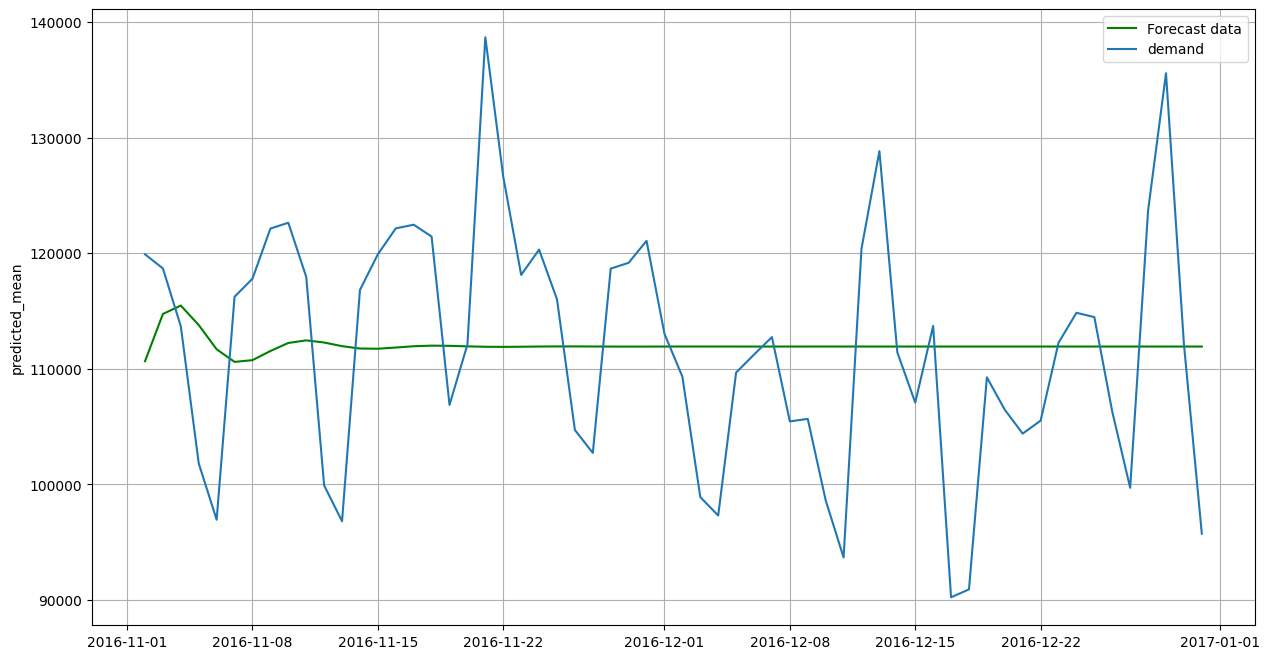

In [33]:
plt.figure(figsize=(15, 8))
sns.lineplot(arima_forecast, 
             color='green', 
             label='Forecast data')
sns.lineplot(test_data, 
             linestyle='--', 
             color='rebeccapurple')
plt.grid()
plt.show()

## Single Exponential Smoothing

In [34]:
es_model = ExponentialSmoothing(train_data, 
                                trend=None, 
                                seasonal=None, 
                                initialization_method='estimated')
result_es = es_model.fit()
result_es.summary()

Dep. Variable:,demand,No. Observations:,671
Model:,ExponentialSmoothing,SSE,85009956362.861
Optimized:,True,AIC,12523.025
Trend:,None,BIC,12532.042
Seasonal:,None,AICC,12523.085
Seasonal Periods:,None,Date:,"Sat, 15 Mar 2025"
Box-Cox:,False,Time:,17:56:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,1.2001e+05,l.0,True


In [35]:
es_forecast = result_es.forecast(len(test_data))

In [36]:
mean_squared_error(test_data, es_forecast, squared=False)

12449.809986985952

In [37]:
mean_absolute_percentage_error(test_data, es_forecast)

0.08876323525687337

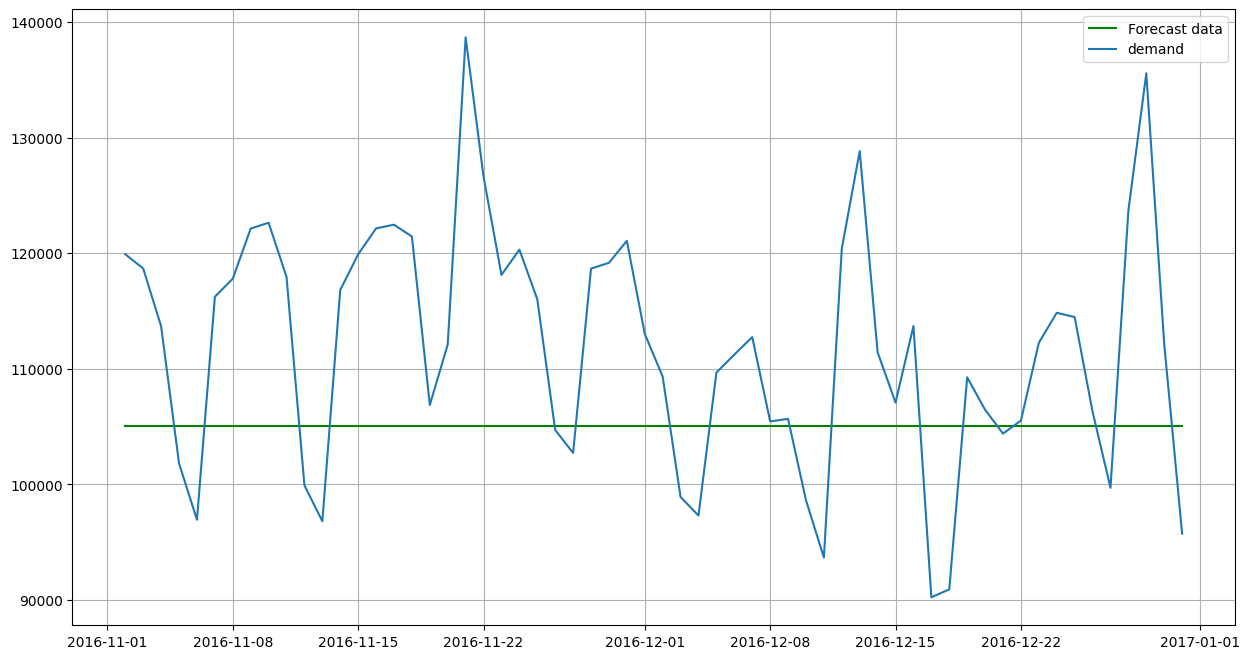

In [38]:
plt.figure(figsize=(15, 8))
sns.lineplot(es_forecast, color='green', label='Forecast data')
sns.lineplot(test_data, linestyle='--', color='rebeccapurple')
plt.grid()
plt.show()

### Double Exponential Smoothing

In [39]:
des_model = ExponentialSmoothing(train_data['demand'], 
                                 trend='add', 
                                 seasonal=None, 
                                 initialization_method='estimated')
result_des = des_model.fit()
result_des.summary()

Dep. Variable:,demand,No. Observations:,671
Model:,ExponentialSmoothing,SSE,85464217463.723
Optimized:,True,AIC,12530.601
Trend:,Additive,BIC,12548.636
Seasonal:,None,AICC,12530.727
Seasonal Periods:,None,Date:,"Sat, 15 Mar 2025"
Box-Cox:,False,Time:,17:56:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


In [40]:
des_model = Holt(train_data, 
                 initialization_method='estimated')
result_des = des_model.fit()
result_des.summary()

Dep. Variable:,demand,No. Observations:,671
Model:,Holt,SSE,85464217463.723
Optimized:,True,AIC,12530.601
Trend:,Additive,BIC,12548.636
Seasonal:,None,AICC,12530.727
Seasonal Periods:,None,Date:,"Sat, 15 Mar 2025"
Box-Cox:,False,Time:,17:56:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


In [41]:
des_forecast = result_des.forecast(len(test_data))

In [42]:
mean_squared_error(test_data['demand'], des_forecast, squared=False)

24749.53068616034

In [43]:
mean_absolute_percentage_error(test_data['demand'], des_forecast)

0.1916372664677453

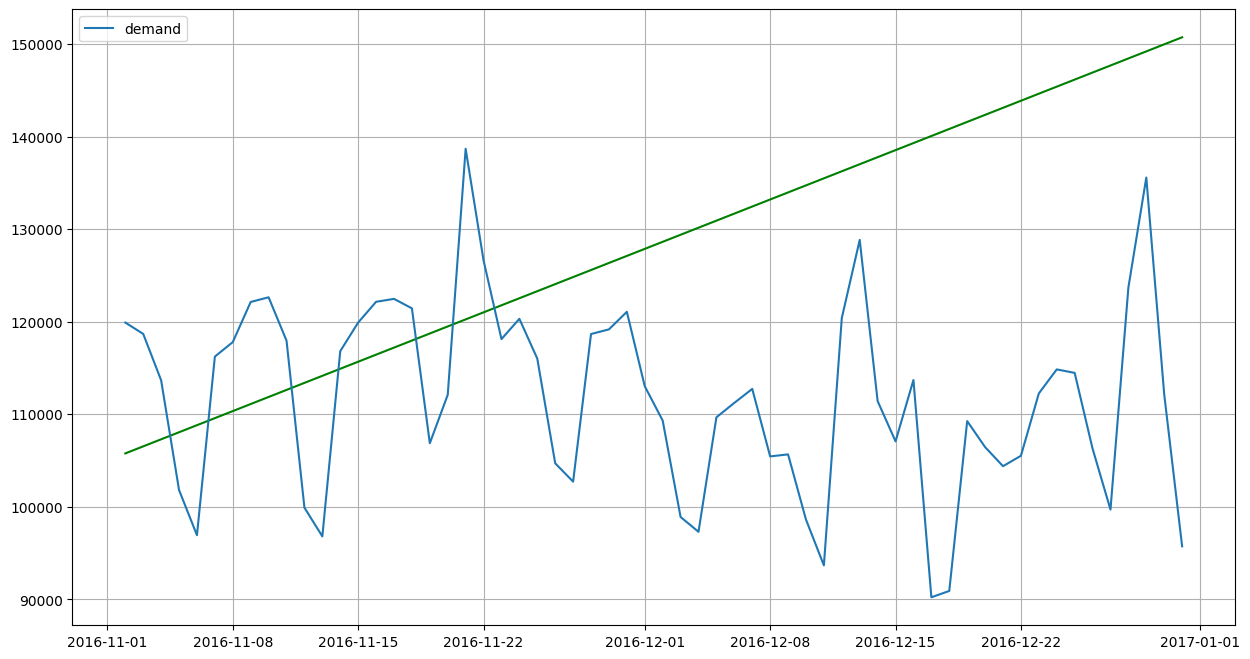

In [44]:
plt.figure(figsize=(15, 8))
sns.lineplot(des_forecast, color='green')
sns.lineplot(test_data, linestyle='--', color='rebeccapurple')
plt.grid()
plt.show()

### Triple Exponential Smoothing

In [45]:
tes_model = ExponentialSmoothing(train_data, 
                                 trend='add', 
                                 seasonal='mul', 
                                 initialization_method='estimated')
result_tes = tes_model.fit()
result_tes.summary()

Dep. Variable:,demand,No. Observations:,671
Model:,ExponentialSmoothing,SSE,42975135572.738
Optimized:,True,AIC,12083.304
Trend:,Additive,BIC,12132.901
Seasonal:,Multiplicative,AICC,12083.858
Seasonal Periods:,7,Date:,"Sat, 15 Mar 2025"
Box-Cox:,False,Time:,17:56:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5353571,alpha,True
smoothing_trend,0.0254932,beta,True


In [46]:
tes_train_forecast = result_tes.predict(start=train_data.index[0], 
                                        end=train_data.index[-1])

In [47]:
print("Train RMSE:", mean_squared_error(train_data, 
                                        tes_train_forecast, 
                                        squared=False))
print("Train MAPE:", mean_absolute_percentage_error(train_data, 
                                                    tes_train_forecast))

Train RMSE: 8002.899583760084
Train MAPE: 0.045887039601441706


In [48]:
tes_test_forecast = result_tes.forecast(len(test_data))

In [49]:
print("Test RMSE:", mean_squared_error(test_data, 
                                       tes_test_forecast, 
                                       squared=False))

Test RMSE: 21350.586876418583


In [50]:
print("Test MAPE:", mean_absolute_percentage_error(test_data, 
                                                   tes_test_forecast))

Test MAPE: 0.17098377131143483


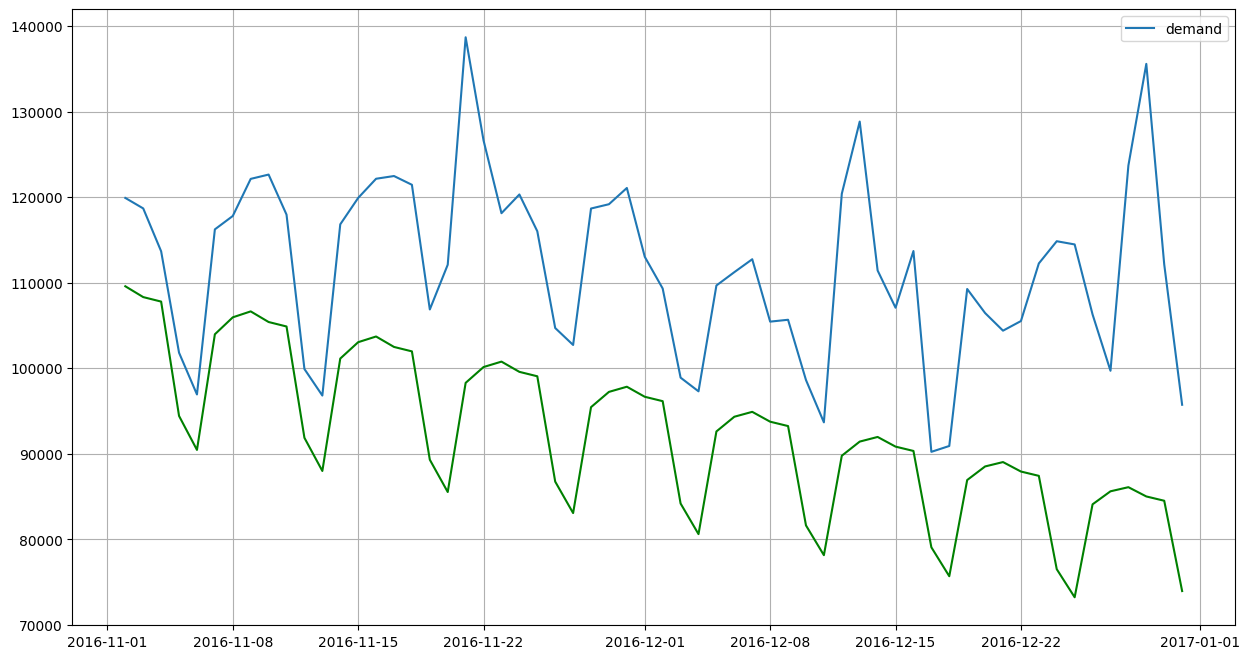

In [51]:
plt.figure(figsize=(15, 8))
sns.lineplot(tes_test_forecast, color='green')
sns.lineplot(test_data, color='rebeccapurple')
plt.grid()
plt.show()

### Tuning

In [52]:
alphas = betas = gammas = np.linspace(0, 1.0, 10)
best_score = float('inf')
best_params = None

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                exp_model = ExponentialSmoothing(train_data, 
                                                 trend='add', 
                                                 seasonal='add', 
                                                 initialization_method='estimated')
                result_exp = exp_model.fit(smoothing_level=alpha, 
                                           smoothing_trend=beta, 
                                           smoothing_seasonal=gamma)
                error = np.mean(np.abs(result_exp.resid))
                if error < best_score:
                    best_params = (alpha, beta, gamma)
                    best_score = error
            except:
                print('Value not possible for model.')
print("Best params:", best_params)

Best params: (0.8888888888888888, 0.0, 0.0)


In [53]:
tes_tuned_model = ExponentialSmoothing(train_data, 
                                       trend='add', 
                                       seasonal='add', 
                                       initialization_method='estimated')

In [54]:
result_exp = exp_model.fit(smoothing_level=best_params[0], 
                           smoothing_trend=best_params[1],
                           smoothing_seasonal=best_params[2])

In [55]:
result_exp.summary()

Dep. Variable:,demand,No. Observations:,671
Model:,ExponentialSmoothing,SSE,35047357578.047
Optimized:,True,AIC,11946.473
Trend:,Additive,BIC,11996.070
Seasonal:,Additive,AICC,11947.027
Seasonal Periods:,7,Date:,"Sat, 15 Mar 2025"
Box-Cox:,False,Time:,17:59:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8888889,alpha,False
smoothing_trend,0.000000,beta,False


In [56]:
tes_tuned_forecast = result_exp.forecast(len(test_data))

In [57]:
mean_squared_error(test_data, tes_tuned_forecast, squared=False)

13855.300118186187

In [58]:
mean_absolute_percentage_error(test_data, tes_tuned_forecast)

0.10145399347828515

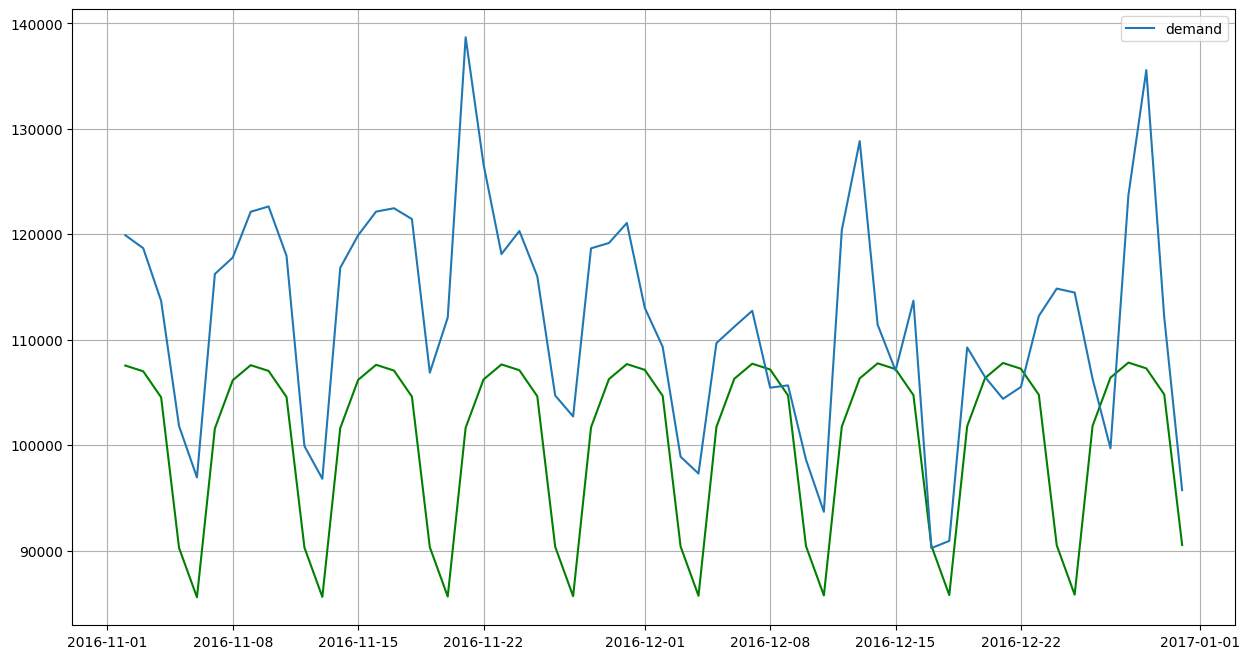

In [59]:
plt.figure(figsize=(15, 8))
sns.lineplot(tes_tuned_forecast, color='green')
sns.lineplot(test_data, linestyle='--', color='rebeccapurple')
plt.grid()
plt.show()

## SARIMAX Model - With tuning of hyperparameters

In [60]:
p = q = range(0, 3)
d = range(1, 2)

pdq = list(itertools.product(p, d, q))
model_pdq = [(p, d, q, 12) for p, d, q in pdq]
aic_df = []

for param in pdq:
    for param_seasonal in model_pdq:
        model = sm.tsa.SARIMAX(train_data, 
                               order=param, 
                               seasonal_order=param_seasonal, 
                               enforce_invertibility=False, 
                               enforce_stationarity=False)
        results = model.fit()
        aic_df.append((param, param_seasonal, results.aic))
    print(f"Iteration compelete for {param}.")

aic_df = pd.DataFrame(data=aic_df, 
                      columns=["Param", "Seasonal", "AIC"]).sort_values(by="AIC", 
                                                                        ascending=True)
print('AIC Calc done')
display(aic_df)

Iteration compelete for (0, 1, 0).
Iteration compelete for (0, 1, 1).
Iteration compelete for (0, 1, 2).
Iteration compelete for (1, 1, 0).
Iteration compelete for (1, 1, 1).
Iteration compelete for (1, 1, 2).
Iteration compelete for (2, 1, 0).
Iteration compelete for (2, 1, 1).
Iteration compelete for (2, 1, 2).
AIC Calc done


,Param,Seasonal,AIC
74,"(2, 1, 2)","(0, 1, 2, 12)",13410.716384
77,"(2, 1, 2)","(1, 1, 2, 12)",13411.069445
80,"(2, 1, 2)","(2, 1, 2, 12)",13428.618028
79,"(2, 1, 2)","(2, 1, 1, 12)",13444.432597
50,"(1, 1, 2)","(1, 1, 2, 12)",13464.003462
...,...,...,...
54,"(2, 1, 0)","(0, 1, 0, 12)",14552.391421
36,"(1, 1, 1)","(0, 1, 0, 12)",14649.964577
9,"(0, 1, 1)","(0, 1, 0, 12)",14675.414546
27,"(1, 1, 0)","(0, 1, 0, 12)",14714.831817


In [61]:
sarimax_model = sm.tsa.SARIMAX(train_data, 
                             order=aic_df.iloc[0]['Param'], 
                             seasonal_order=aic_df.iloc[0]['Seasonal'], 
                             enforce_invertibility=False, 
                             enforce_stationarity=False)

In [62]:
result_sarimax = sarimax_model.fit(smoothing_level=best_params[0], 
                                   smoothing_trend=best_params[1], 
                                   smoothing_seasonal=best_params[2])

In [63]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             demand   No. Observations:                  671
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -6698.358
Date:                            Sat, 15 Mar 2025   AIC                          13410.716
Time:                                    18:08:53   BIC                          13441.848
Sample:                                01-01-2015   HQIC                         13422.808
                                     - 11-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1590      0.093     12.528      0.000       0.978       1.340
ar.L2         -0.6739      0.074     -9.100      0.000      -0.819      -0.529
ma.L1         -1.4306      0.105    -13.574      0.000      -1.637      -1.224
ma.L2          0.5362      0.099      5.395      0.000       0.341       0.731
ma.S.L12      -1.1556      0.065    -17.878      0.000      -1.282      -1.029
ma.S.L24       0.3104      0.061      5.050      0.000       0.190       0.431
sigma2      1.547e+08    3.9e-10   3.97e+17      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                14.31
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.26
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.41e+33. Standard errors may be unstable.
"""

In [64]:
sarimax_train_forecast = result_sarimax.predict(start=train_data.index[0], 
                                                end=train_data.index[-1]) 

In [65]:
print("Train RMSE:", mean_squared_error(train_data, 
                                        sarimax_train_forecast, 
                                        squared=False))
print("Train MAPE:", mean_absolute_percentage_error(train_data, 
                                                    sarimax_train_forecast))

Train RMSE: 12513.848476617604
Train MAPE: 0.06929782589287237


In [66]:
sarimax_test_forecast = result_sarimax.forecast(len(test_data))

In [67]:
mean_squared_error(test_data, sarimax_test_forecast, squared=False)

12469.210324522943

In [68]:
mean_absolute_percentage_error(test_data, sarimax_test_forecast)

0.08990914514418114

In [69]:
residuals = test_data['demand'] - sarimax_test_forecast

In [70]:
residuals[:5]

2016-11-02     9192.540503
2016-11-03     1929.231188
2016-11-04    -3090.509705
2016-11-05   -10077.441760
2016-11-06   -13568.294531
Freq: D, dtype: float64

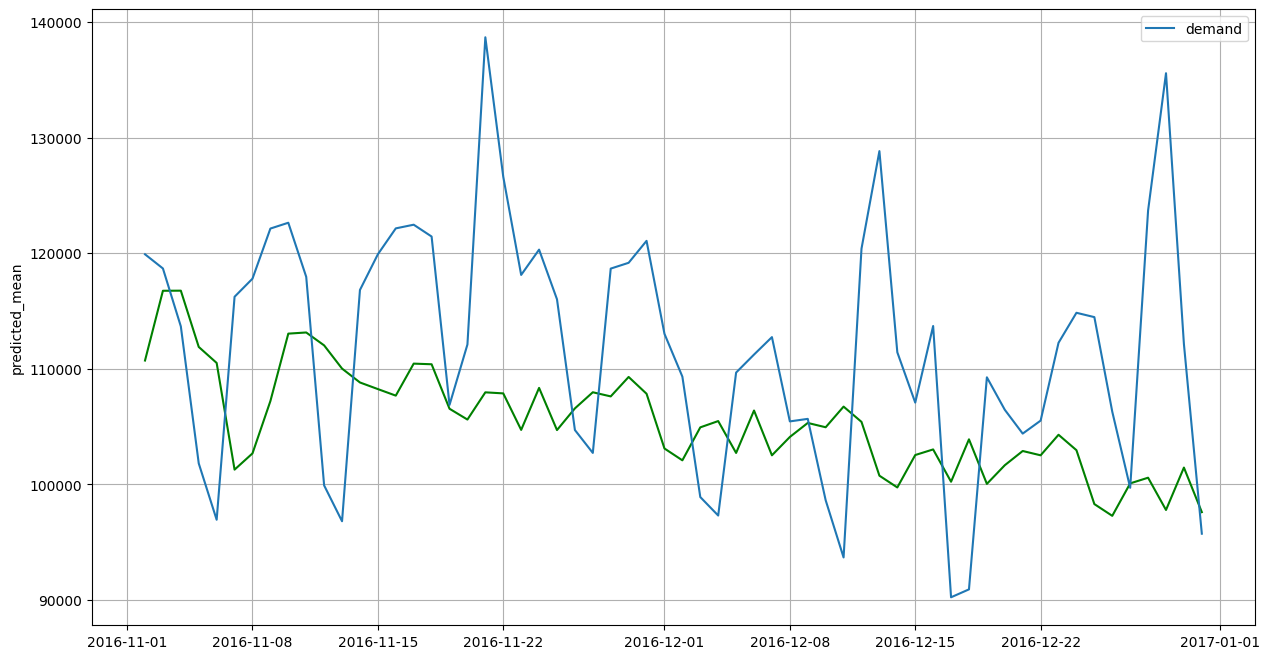

In [71]:
plt.figure(figsize=(15, 8))
sns.lineplot(sarimax_test_forecast, color='green')
sns.lineplot(test_data, color='rebeccapurple')
plt.grid()
plt.show()

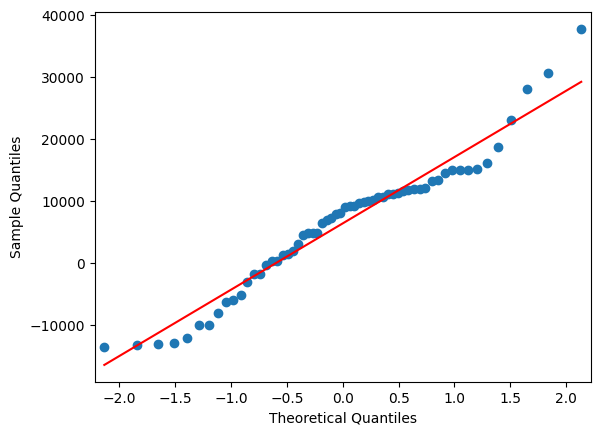

In [72]:
qqplot(data=residuals, line='s');

<Axes: ylabel='Count'>

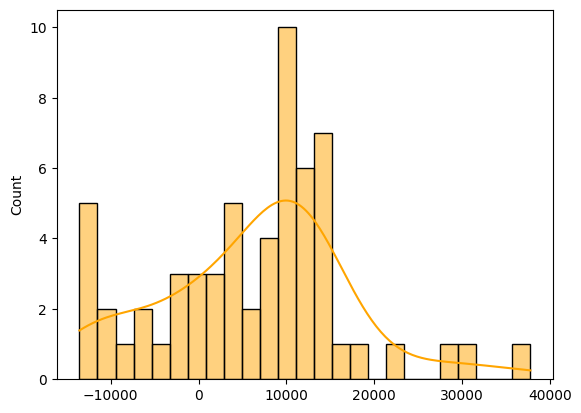

In [73]:
sns.histplot(data=residuals, kde=True, color='orange', bins=25)

In [74]:
residuals.skew()

0.15955252704970016

### Predict for next one month

In [75]:
final_model = sm.tsa.SARIMAX(electricity_data, 
                             order=aic_df.iloc[0]['Param'], 
                             seasonal_order=aic_df.iloc[0]['Seasonal'], 
                             enforce_invertibility=False, 
                             enforce_stationarity=False)

In [76]:
result_final = final_model.fit(smoothing_level=best_params[0], 
                               smoothing_trend=best_params[1], 
                               smoothing_seasonal=best_params[2])

In [77]:
result_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             demand   No. Observations:                  731
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -7335.901
Date:                            Sat, 15 Mar 2025   AIC                          14685.803
Time:                                    18:09:10   BIC                          14717.570
Sample:                                01-01-2015   HQIC                         14698.090
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1405      0.089     12.795      0.000       0.966       1.315
ar.L2         -0.6655      0.070     -9.523      0.000      -0.802      -0.529
ma.L1         -1.4280      0.101    -14.194      0.000      -1.625      -1.231
ma.L2          0.5337      0.095      5.610      0.000       0.347       0.720
ma.S.L12      -1.1443      0.062    -18.426      0.000      -1.266      -1.023
ma.S.L24       0.2942      0.059      4.983      0.000       0.178       0.410
sigma2      1.535e+08   3.92e-10   3.91e+17      0.000    1.54e+08    1.54e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                18.27
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.30
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.34e+33. Standard errors may be unstable.
"""

In [78]:
final_forecast = result_final.forecast(30)

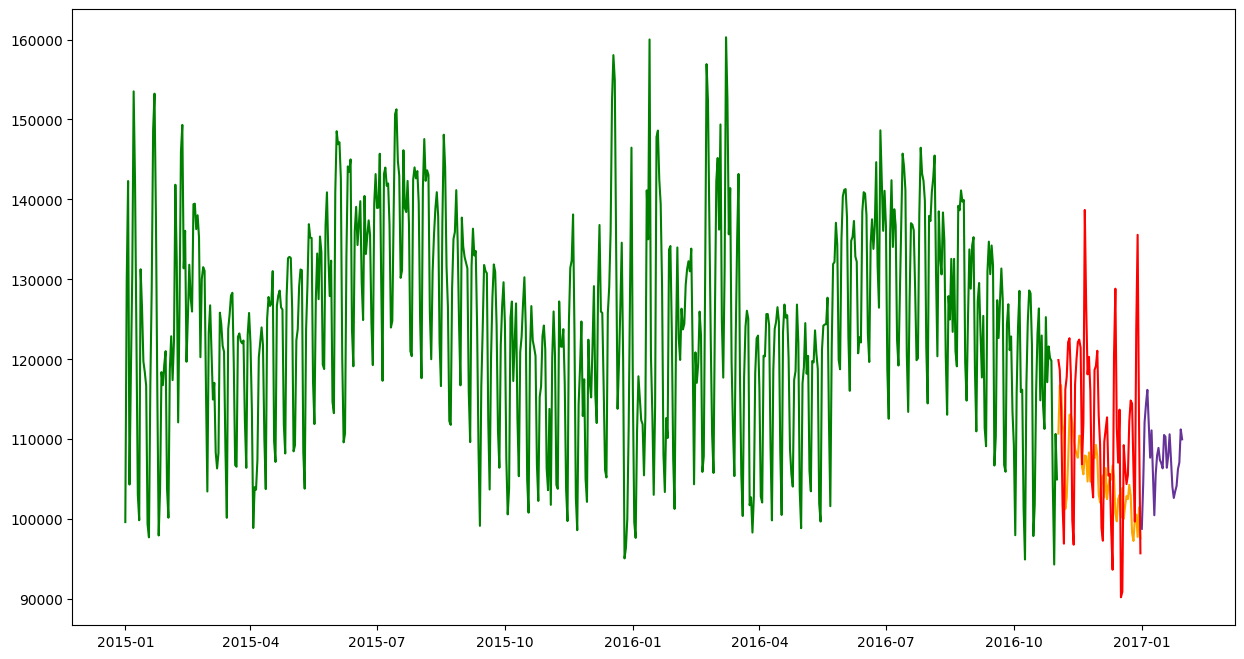

In [79]:
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data.demand, color='green')
plt.plot(test_data.index, sarimax_test_forecast, color='orange')
plt.plot(test_data.index, test_data.demand, color='red')
plt.plot(final_forecast, color='rebeccapurple')
plt.show()

In [80]:
submission_df = pd.DataFrame(final_forecast)
submission_df.rename(columns={'predicted_mean': 'Demand'}, inplace=True)

In [81]:
display(submission_df.head(2))
display(submission_df.tail(2))

,Demand
2017-01-01,98789.864732
2017-01-02,104392.082637


,Demand
2017-01-29,111226.419857
2017-01-30,109991.145491


In [82]:
submission_df.to_csv('../d. Output Files/Electricity Demand/Electricity Demand Forecast.csv', index=True)